In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns

# data precession
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


# model
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

/Users/lianfangyuan/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def load_train_data():
    train = pd.read_csv('input/train_2016_v2.csv')
#     train_2017 = pd.read_csv('input/train_2017.csv')
#     train = pd.concat([train_2016, train_2017], axis=0)
    
    properties = pd.read_csv('input/properties_2016.csv')

    sample = pd.read_csv('input/sample_submission.csv')
    sample = sample.rename(columns={'ParcelId': 'parcelid'})
    
    #train = train.merge(properties, on='parcelid', how='left')
    print(train.shape, properties.shape, sample.shape)
    
    return train, properties, sample

# Load data set
train_df, properties, sample_df = load_train_data()

(90275, 3) (2985217, 58) (2985217, 7)


In [3]:
count = properties.isnull().sum()
ratio = count / len(properties)
null_data = pd.concat([count,ratio],axis=1,keys=['count','ratio'])
null_data

,count,ratio
parcelid,0,0.000000
airconditioningtypeid,2173698,0.728154
architecturalstyletypeid,2979156,0.997970
basementsqft,2983589,0.999455
bathroomcnt,11462,0.003840
bedroomcnt,11450,0.003836
buildingclasstypeid,2972588,0.995769
buildingqualitytypeid,1046729,0.350637
calculatedbathnbr,128912,0.043183
decktypeid,2968121,0.994273


In [4]:
index = []
for i, v in enumerate(ratio):
    if v > 0.5:
        index.append(i)

In [5]:
properties.drop(properties.columns[index], axis = 1, inplace=True)

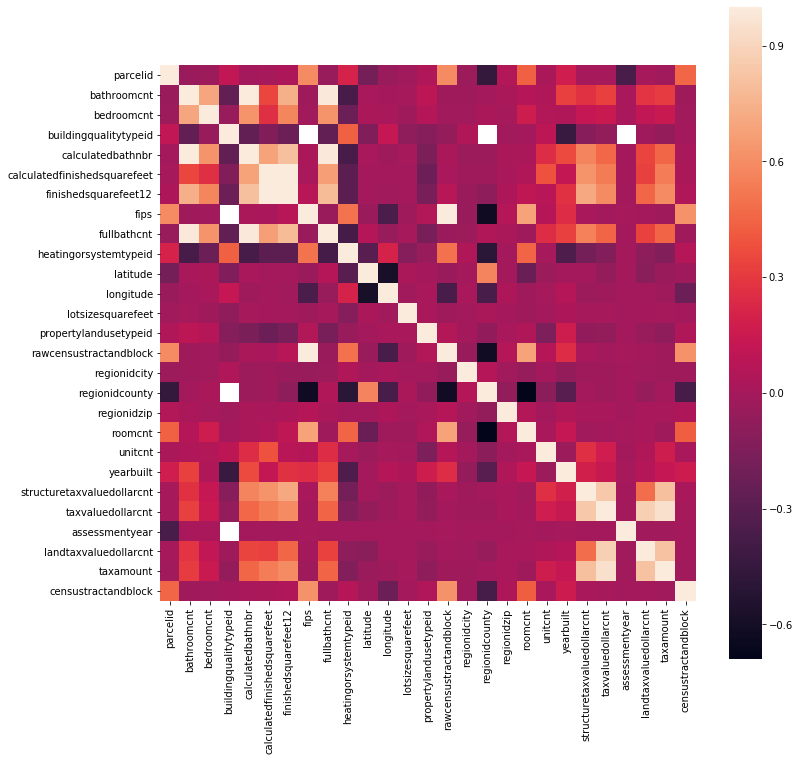

In [6]:
correlation = properties.corr()
plt.subplots(figsize=(12, 12))
sns.heatmap(correlation, square=True)
plt.show()

Heatmap shows that 'bathroomcnt' and 'bedroomcnt',\
                   'calculatedbathnbr', 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12'\
                   'structuretaxvaluedollarcnt' and 'taxvaluedollarcnt'\
                   'landtaxvaluedollarcnt' and 'taxmount' have high correlation.                   

In [7]:
properties.shape

(2985217, 29)

In [9]:
# Add feature
properties['citycode'] = properties['propertycountylandusecode'].apply(lambda x: str(x)[0:3])
lbl = LabelEncoder()
lbl.fit(list(properties['citycode'].values))
properties['citycode'] = lbl.transform(list(properties['citycode'].values))

properties['livingareaerror'] = properties['calculatedfinishedsquarefeet'] / properties['finishedsquarefeet12']

properties['livingareaprop'] = properties['calculatedfinishedsquarefeet'] / properties['lotsizesquarefeet']

properties['extraspace'] = properties['lotsizesquarefeet'] - properties['calculatedfinishedsquarefeet']

properties['life'] = 2019 - properties['yearbuilt']

properties['totalrooms'] = properties['bathroomcnt'] + properties['bedroomcnt']

properties['averageroomsize'] = properties['calculatedfinishedsquarefeet'] / properties['roomcnt']

properties['extrarooms'] = properties['roomcnt'] - properties['totalrooms']

properties['valueproportion'] = properties['structuretaxvaluedollarcnt'] / properties['landtaxvaluedollarcnt']

properties["location1"] = properties["latitude"] + properties["longitude"]

properties["location2"] = properties["latitude"] * properties["longitude"]

properties['taxratio'] = properties['taxvaluedollarcnt'] / properties['taxamount']

zip_count = properties['regionidzip'].value_counts().to_dict()
properties['zipcount'] = properties['regionidzip'].map(zip_count)

city_count = properties['regionidcity'].value_counts().to_dict()
properties['citycount'] = properties['regionidcity'].map(city_count)

region_count = properties['regionidcounty'].value_counts().to_dict()
properties['countycount'] = properties['regionidcounty'].map(region_count)

In [12]:
properties.shape

(2985217, 44)

In [10]:
# train = train_df.merge(properties, on='parcelid', how='left')
# test = sample_df.merge(properties, on='parcelid', how='left')
# train = train[train.logerror > -0.4]
# train = train[train.logerror < 0.42]
# drop_feature = ['parcelid', 'logerror', 'transactiondate']

# x_train = train.drop(drop_feature, axis=1)
# y_train = train['logerror'].values
# x_test = test[x_train.columns]

In [11]:
# xgb_params = {}
# xgb_params['n_estimators'] = 250
# xgb_params['min_child_weight'] = 12
# xgb_params['learning_rate'] = 0.03
# xgb_params['max_depth'] = 10
# xgb_params['subsample'] = 0.8
# xgb_params['reg_lambda'] = 0.8
# xgb_params['reg_alpha'] = 0.4
# xgb_params['base_score'] = 0
# xgb_params['silent'] = 1

# param_test = {
#     'n_estimators': range(30, 50, 2),
#     'max_depth': range(2, 7, 1)
# }

# xgb_model = XGBRegressor(xgb_params)
# grid_xgb = GridSearchCV(estimator=xgb_model, param_grid = param_test,scoring='neg_mean_absolute_error', cv=5)
# grid_xgb.fit(x_train, y_train)
# grid_xgb.grid_scores_, grid_xgb.best_params_, grid_xgb.best_score_

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields propertycountylandusecode, propertyzoningdesc